In [57]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Activation, LSTM, Conv2D
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


In [2]:
dataset = pd.read_csv('datas.csv',low_memory=False)

In [3]:
dataset.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [4]:
dataset.columns

Index(['Category', 'pslist.nproc', 'pslist.nppid', 'pslist.avg_threads',
       'pslist.nprocs64bit', 'pslist.avg_handlers', 'dlllist.ndlls',
       'dlllist.avg_dlls_per_proc', 'handles.nhandles',
       'handles.avg_handles_per_proc', 'handles.nport', 'handles.nfile',
       'handles.nevent', 'handles.ndesktop', 'handles.nkey', 'handles.nthread',
       'handles.ndirectory', 'handles.nsemaphore', 'handles.ntimer',
       'handles.nsection', 'handles.nmutant', 'ldrmodules.not_in_load',
       'ldrmodules.not_in_init', 'ldrmodules.not_in_mem',
       'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_init_avg',
       'ldrmodules.not_in_mem_avg', 'malfind.ninjections',
       'malfind.commitCharge', 'malfind.protection',
       'malfind.uniqueInjections', 'psxview.not_in_pslist',
       'psxview.not_in_eprocess_pool', 'psxview.not_in_ethread_pool',
       'psxview.not_in_pspcid_list', 'psxview.not_in_csrss_handles',
       'psxview.not_in_session', 'psxview.not_in_deskthrd',
       'psxv

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

In [6]:
dataset.describe()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
count,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,5.859600e+04,58596.000000,58596.0,...,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,58596.000000
mean,41.394771,14.713837,11.341655,0.0,247.509819,1810.805447,43.707806,1.025858e+04,249.560958,0.0,...,391.347549,221.406581,25.996245,25.063417,116.879514,0.0,121.995546,86.905659,0.000853,7.999881
std,5.777249,2.656748,1.588231,0.0,111.857790,329.782639,5.742023,4.866864e+03,145.999866,0.0,...,4.529704,1.991087,0.170790,1.529628,1.550401,0.0,2.822858,3.134117,0.029199,0.010929
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,94.000000,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000
25%,40.000000,12.000000,9.972973,0.0,208.725000,1556.000000,38.833333,8.393000e+03,209.648228,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000
50%,41.000000,15.000000,11.000000,0.0,243.963710,1735.000000,42.781524,9.287500e+03,247.208951,0.0,...,389.000000,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000
75%,43.000000,16.000000,12.861955,0.0,289.974322,2087.000000,49.605280,1.219300e+04,291.355050,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,395.000000,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000


In [7]:
labels = dataset['Class'].apply(lambda x:0 if x == "Benign" else 1)
datanumaric = dataset.apply(pd.to_numeric, errors='coerce')
datanumaric.replace([np.inf,-np.inf], np.nan, inplace=True)
datanumaric.replace(np.nan, 0, inplace=True)
columns_to_drop = [col for col in datanumaric.columns if datanumaric[col].eq(0).all()]
datanumaric.drop(columns=columns_to_drop, inplace=True)

In [8]:
datanumaric.head()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nfile,handles.nevent,...,modules.nmodules,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
0,45,17,10.555556,202.844444,1694,38.500000,9129,212.302326,670,3161,...,138,389,221,26,24,116,121,87,0,8
1,47,19,11.531915,242.234043,2074,44.127660,11385,242.234043,840,3761,...,138,392,222,26,24,118,122,87,0,8
2,40,14,14.725000,288.225000,1932,48.300000,11529,288.225000,1050,3996,...,137,395,222,26,27,118,120,88,0,8
3,32,13,13.500000,264.281250,1445,45.156250,8457,264.281250,630,2961,...,138,395,222,26,27,118,120,88,0,8
4,42,16,11.452381,281.333333,2067,49.214286,11816,281.333333,908,3834,...,138,392,222,26,24,118,124,87,0,8


In [9]:
dataset.groupby('Class').agg({'Class':'first', 'Class':'count'}).rename_axis(None).sort_values('Class', ascending=False)

,Class
Benign,29298
Malware,29298


In [10]:
data = dataset['Class'].apply(lambda x:0 if x == "Benign" else 1)

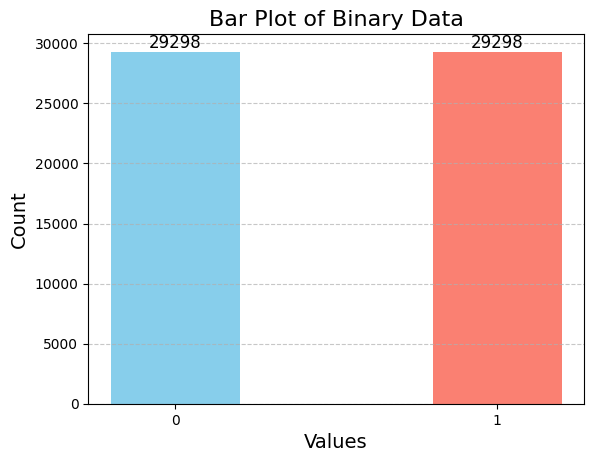

In [11]:
value_counts = data.value_counts()
plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'salmon'], width=0.4)
plt.title('Bar Plot of Binary Data', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, count in enumerate(value_counts.values):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12)
plt.xticks(value_counts.index, ['0', '1'])
plt.show()

In [12]:
corr = datanumaric.corr()

In [13]:
def get_abs_correlations(df, t):
    labels_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]-2):
        for j in range(0, i+1):
            labels_to_drop.add((cols[i], cols[j]))
    
    c = corr.abs().unstack().drop(labels=labels_to_drop).sort_values(ascending=False)
    return c[c > t]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(get_abs_correlations(datanumaric, 0.8))

callbacks.ngeneric                      callbacks.ngeneric                        1.000000
callbacks.nanonymous                    callbacks.nanonymous                      1.000000
ldrmodules.not_in_load                  ldrmodules.not_in_mem                     0.999994
psxview.not_in_pslist                   psxview.not_in_session                    0.999986
ldrmodules.not_in_load_avg              ldrmodules.not_in_mem_avg                 0.999980
malfind.ninjections                     malfind.protection                        0.999955
psxview.not_in_ethread_pool             psxview.not_in_csrss_handles              0.999888
psxview.not_in_pslist_false_avg         psxview.not_in_session_false_avg          0.993937
pslist.avg_handlers                     handles.avg_handles_per_proc              0.992540
psxview.not_in_pslist                   psxview.not_in_pspcid_list                0.992038
psxview.not_in_pspcid_list              psxview.not_in_session                    0.992028

In [14]:
datanumaric = pd.concat([datanumaric, pd.DataFrame(labels).astype('float64')], axis=1)

In [15]:
labels = datanumaric['Class']
features = datanumaric.loc[:, datanumaric.columns != 'Class'].astype('float64')

In [16]:
features.head()

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nfile,handles.nevent,...,modules.nmodules,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
0,45.0,17.0,10.555556,202.844444,1694.0,38.500000,9129.0,212.302326,670.0,3161.0,...,138.0,389.0,221.0,26.0,24.0,116.0,121.0,87.0,0.0,8.0
1,47.0,19.0,11.531915,242.234043,2074.0,44.127660,11385.0,242.234043,840.0,3761.0,...,138.0,392.0,222.0,26.0,24.0,118.0,122.0,87.0,0.0,8.0
2,40.0,14.0,14.725000,288.225000,1932.0,48.300000,11529.0,288.225000,1050.0,3996.0,...,137.0,395.0,222.0,26.0,27.0,118.0,120.0,88.0,0.0,8.0
3,32.0,13.0,13.500000,264.281250,1445.0,45.156250,8457.0,264.281250,630.0,2961.0,...,138.0,395.0,222.0,26.0,27.0,118.0,120.0,88.0,0.0,8.0
4,42.0,16.0,11.452381,281.333333,2067.0,49.214286,11816.0,281.333333,908.0,3834.0,...,138.0,392.0,222.0,26.0,24.0,118.0,124.0,87.0,0.0,8.0


In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
LE = LabelEncoder()
LE.fit(labels)
labels = LE.transform(labels)

In [19]:
np.unique(labels)

array([0, 1], dtype=int64)

### Splitting the data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size= 0.2,random_state=1)
features_train.shape, labels_train.shape ,features_test.shape , labels_test.shape

((46876, 52), (46876,), (11720, 52), (11720,))

In [22]:
# this function has evaluation metrics
def report(prediction, y_true):
    print('        ----------Classification Report Of Classes-------------')
    print(classification_report(y_true,prediction))
    print('\n        ----------Validation Data------------------')
    print('Accuarcy:',accuracy_score(y_true, prediction)* 100)
    print('Precision: {:,.4f} %'.format(precision_score(y_true, prediction) * 100))
    print('Recall-score: {:,.4f}'.format(recall_score(y_true, prediction) * 100))
    print('F1-score: {:,.4f}'.format(f1_score(y_true, prediction) * 100))

In [23]:
def plotgraphs(history):
    f, ax = plt.subplots()
    ax.plot([None] + history["accuracy"], 'o-')
    ax.plot([None] + history["val_accuracy"], 'x-')

    ax.legend(['Train_Accuracy', 'Val_Accuracy'], loc = 0)
    ax.set_title('Training/Val Accuracy Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('acc')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + history["loss"], 'o-')
    ax.plot([None] + history["val_loss"], 'x-')

    ax.legend(['Train_Loss', 'Val_Loss'], loc = 0)
    ax.set_title('Training/Val Losses Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    plt.show()

    f, ax = plt.subplots()
    ax.plot([None] + history["learning_rate"], 'o-')

    ax.legend(['Learning Rate'], loc = 0)
    ax.set_title('Learning Rate Change Per Epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel('learning_rate')
    plt.show()

In [24]:
def squash(vectors, axis=-1):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
    return scale * vectors

In [25]:
class PrimaryCap(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, kernel_size=3, strides=1, **kwargs):
        super(PrimaryCap, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.kernel_size = kernel_size
        self.strides = strides

    def build(self, input_shape):
        self.conv_layer = Conv2D(filters=self.num_capsules * self.dim_capsules,
                                        kernel_size=self.kernel_size,
                                        strides=self.strides,
                                        padding='valid')
        super(PrimaryCap, self).build(input_shape)

    def call(self, inputs):
        outputs = self.conv_layer(inputs)
        outputs = tf.reshape(outputs, (-1, outputs.shape[1] * outputs.shape[2] * self.num_capsules, self.dim_capsules))
        return squash(outputs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsules, self.dim_capsules)

In [26]:
class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, routing_iters=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules
        self.routing_iters = routing_iters

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.dim_capsules],
                                 initializer='glorot_uniform', trainable=True)
        super(CapsuleLayer, self).build(input_shape)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        inputs_hat = tf.einsum('bij,jk->bik', inputs, self.W)
        inputs_hat = tf.reshape(inputs_hat, [batch_size, inputs.shape[1], self.num_capsules, self.dim_capsules])

        b = tf.zeros(shape=[batch_size, inputs.shape[1], self.num_capsules])

        for i in range(self.routing_iters):
            c = tf.nn.softmax(b, axis=2)
            outputs = squash(tf.reduce_sum(c[..., tf.newaxis] * inputs_hat, axis=1, keepdims=True), axis=-2)
            if i < self.routing_iters - 1:
                b += tf.reduce_sum(inputs_hat * outputs, axis=-1)

        return tf.squeeze(outputs, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_capsules, self.dim_capsules)

In [27]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")

        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

In [28]:
model = Sequential()

model.add(Dense(64, kernel_initializer=GlorotUniform(seed=42), input_dim=52))
model.add(Reshape((4, 4, 4)))

model.add(PrimaryCap(num_capsules=8, dim_capsules=16, kernel_size=3, strides=1))

model.add(LSTM(64, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(LSTM(32, return_sequences=True, kernel_initializer=GlorotUniform(seed=42)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(CapsuleLayer(num_capsules=8, dim_capsules=16))

model.add(AttentionLayer())

model.add(Dense(2, activation='softmax'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ primary_cap (PrimaryCap)        │ (None, 8, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 64)          │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer (CapsuleLayer)    │ (None, 8, 16)          │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 16)             │            24 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,082 (160.48 KB)

 Trainable params: 40,890 (159.73 KB)

 Non-trainable params: 192 (768.00 B)

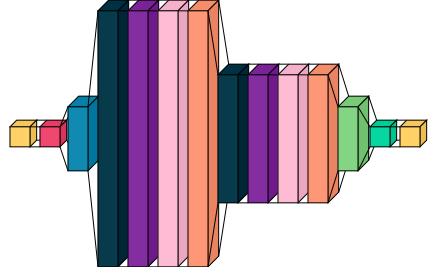

In [29]:
import visualkeras
visualkeras.layered_view(model)

In [30]:
def lr_warmup(epoch, lr):
    warmup_epochs = 5
    if epoch < warmup_epochs:
        return lr * (epoch + 1) / warmup_epochs
    return lr

In [31]:
import numpy as np
import tensorflow as tf

class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = tf.Variable(base_lr, dtype=tf.float32)
        self.max_lr = tf.Variable(max_lr, dtype=tf.float32)
        self.step_size = step_size
        self.mode = mode
        self.iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.iterations / (2 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1)
        scale_factor = 1

        if self.mode == 'triangular2':
            scale_factor = 1 / (2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            scale_factor = 0.999 ** self.iterations

        return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) * scale_factor

    def on_train_begin(self, logs=None):
        if logs is None:
            logs = {}
        tf.keras.backend.set_value(self.max_lr, self.base_lr.numpy())

    def on_batch_end(self, batches, logs=None):
        self.iterations += 1
        lr = self.clr()
        tf.keras.backend.set_value(self.base_lr, lr)
        
        self.history.setdefault('lr', []).append(lr.numpy())
        self.history.setdefault('iterations', []).append(self.iterations)
        
        if logs is not None:
            for k, v in logs.items():
                self.history.setdefault(k, []).append(v)
        else:
            logs = {}

In [32]:
class CustomHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.history = {
            'accuracy': [],
            'loss': [],
            'val_accuracy': [],
            'val_loss': [],
            'learning_rate': []
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['loss'].append(logs.get('loss'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['learning_rate'].append(logs.get('learning_rate'))

In [33]:
history = CustomHistoryCallback()

In [34]:
clr = CyclicLR(base_lr= 0.00001, max_lr= 0.001, step_size=2000)

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
lr_sheduler = LearningRateScheduler(lr_warmup)

In [36]:
labels_train_onehot = tf.keras.utils.to_categorical(labels_train, num_classes=2)
labels_test_onehot = tf.keras.utils.to_categorical(labels_test, num_classes=2)

In [37]:
model.fit(
    features_train, labels_train_onehot, 
    epochs=10, batch_size=128,
    callbacks=[early_stopping, reduce_lr, lr_sheduler, clr, history],
    verbose=1
)
model.save('model.keras')

Epoch 1/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 74s 161ms/step - accuracy: 0.8928 - loss: 0.3006 - learning_rate: 0.0020
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 64s 175ms/step - accuracy: 0.9939 - loss: 0.0358 - learning_rate: 8.0000e-04
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 144ms/step - accuracy: 0.9937 - loss: 0.0322 - learning_rate: 4.8000e-04
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 54s 146ms/step - accuracy: 0.9949 - loss: 0.0267 - learning_rate: 3.8400e-04
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 54s 148ms/step - accuracy: 0.9953 - loss: 0.0240 - learning_rate: 3.8400e-04
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 79s 138ms/step - accuracy: 0.9953 - loss: 0.0231 - learning_rate: 3.8400e-04
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 53s 144ms/step - accuracy: 0.9956 - loss: 0.0201 - learning_rate: 3.8400e-04
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 88s 160ms/step - accuracy: 0.9958 - loss: 0.0170 - learning_rate: 3.8400e-04
Epoch 9/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 75s 142ms/step - accuracy: 0

In [38]:
def keras_features(X):
        ret_features =  model.predict(X)
        return ret_features

In [39]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

def create_model():
    keras_transformer = FunctionTransformer(keras_features, validate=False)

    pipeline_rf = Pipeline([
        ('feature_extractor', keras_transformer),
        ('rf', RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=2,
            min_samples_leaf=1,
            random_state=0,
            n_jobs=-1
        ))
    ])

    pipeline_logreg = Pipeline([
        ('feature_extractor', keras_transformer),
        ('logreg', LogisticRegression(max_iter=1000, random_state=0))
    ])

    pipeline_dt = Pipeline([
        ('feature_extractor', keras_transformer),
        ('dt', DecisionTreeClassifier(max_depth=15, random_state=0))
    ])


    pipeline_nb = Pipeline([
        ('feature_extractor', keras_transformer),
        ('nb', GaussianNB())
    ])

    ensemble_model = VotingClassifier(estimators=[
        ('rf', pipeline_rf),
        ('logreg', pipeline_logreg),
        ('dt', pipeline_dt),
        ('nb', pipeline_nb)
    ], voting='hard')

    return ensemble_model

In [40]:
en_model = create_model()

In [41]:
en_model.fit(features_train,labels_train)

1465/1465 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step
1465/1465 ━━━━━━━━━━━━━━━━━━━━ 46s 32ms/step


VotingClassifier(estimators=[('rf',
                              Pipeline(steps=[('feature_extractor',
                                               FunctionTransformer(func=<function keras_features at 0x00000223ABE83BA0>)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=15,
                                                                      n_estimators=200,
                                                                      n_jobs=-1,
                                                                      random_state=0))])),
                             ('logreg',
                              Pipeline(steps=[('feature_extractor',
                                               FunctionTransformer(func=<function keras_features at 0x00000223ABE83BA0>)...
                                               LogisticRegression(max_iter=1000,
                                                                  random_state=0))])),
                             ('dt',
                              Pipeline(steps=[('feature_extractor',
                                               FunctionTransformer(func=<function keras_features at 0x00000223ABE83BA0>)),
                                              ('dt',
                                               DecisionTreeClassifier(max_depth=15,
                                                                      random_state=0))])),
                             ('nb',
                              Pipeline(steps=[('feature_extractor',
                                               FunctionTransformer(func=<function keras_features at 0x00000223ABE83BA0>)),
                                              ('nb', GaussianNB())]))])

In [42]:
predictions = en_model.predict(features_test)

367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step


In [43]:
report(predictions,labels_test)

        ----------Classification Report Of Classes-------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5973
           1       1.00      0.99      1.00      5747

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720


        ----------Validation Data------------------
Accuarcy: 99.57337883959045
Precision: 99.7034 %
Recall-score: 99.4258
F1-score: 99.5644


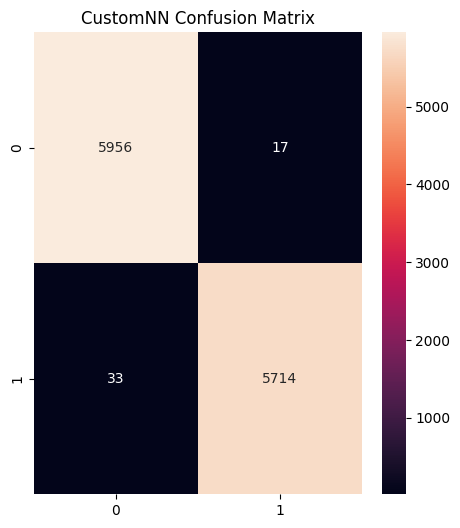

In [44]:
ann_cm = confusion_matrix(labels_test, predictions)
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.heatmap(ann_cm, annot=True, fmt='d')
plt.title('CustomNN Confusion Matrix')
plt.show()

In [78]:
accuracy_ann = accuracy_score(labels_test, predictions) * 100
precision_ann = precision_score(labels_test, predictions) * 100
recall_ann = recall_score(labels_test, predictions) * 100
f1_ann = f1_score(labels_test, predictions) * 100

In [86]:
compare = {
    'Model': ['Custom NN'],
    'Accuracy': [format(accuracy_ann, '.2f')],
    'Precision': [format(precision_ann, '.2f')],
    'Recall': [format(recall_ann, '.2f')],
    'F1-Score': [format(f1_ann, '.2f')]
}

In [49]:
table = pd.DataFrame(compare)
table

,Model,Accuracy,Precision,Recall,F1-Score
0,Custom NN,99.57,99.70,99.43,99.56


In [50]:
import random
random_index = random.choice(datanumaric.index)

In [51]:
random_row = pd.DataFrame(datanumaric.drop(columns=['Class']).iloc[random_index]).T

In [52]:
random_row

,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nfile,handles.nevent,...,modules.nmodules,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric
3234,49.0,21.0,11.286383,275.508262,2439.0,49.11833,13682.0,275.508262,1008.0,4545.0,...,138.0,392.0,222.0,26.0,24.0,118.0,126.0,87.0,0.0,8.0


In [53]:
random_pred = np.argmax(model.predict(random_row))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


In [54]:
if datanumaric['Class'][random_index] == random_pred:
    if random_pred == 1:
        print('Malicious')
    else:
        print('Not Malicious')
else:
    print('Wrong Prediction, Retrain') 

Not Malicious
